#Sentiment Analysis of Comments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')
plt.style.use('ggplot')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [47]:
# Read in data
df = pd.read_csv('/content/sentiment_analysis_data.csv')

# Filter rows based on 'ItemCode'
desired_item_code = 'bZtFJ6hceT'
df = df[df['ItemCode'] == desired_item_code]

print(df.shape)
df = df.head(500)
print(df.shape)

(186, 17)
(186, 17)


In [48]:
df.head()

,Unnamed: 0,ID,BrandName,ItemCode,Rating,Review,UserName,Month,Year,UserCertified,Place,VaderScores,Negative,Neutral,Positive,Compound,Sentiment
13,13,13,indi_club,bZtFJ6hceT,5,I love this product. The fabric of this item i...,Vikas,Oct,2022.0,Certified Buyer,Sangli District,"{'neg': 0.0, 'neu': 0.475, 'pos': 0.525, 'comp...",0.000,0.475,0.525,0.9356,positive
14,14,14,indi_club,bZtFJ6hceT,4,Super quality and fitting 👌 🥰😍🤩,Mahesh MGR,Oct,2022.0,Certified Buyer,Mysuru,"{'neg': 0.0, 'neu': 0.506, 'pos': 0.494, 'comp...",0.000,0.506,0.494,0.5994,positive
15,15,15,indi_club,bZtFJ6hceT,5,This product is very comfortable,Utkal Rout,Dec,2022.0,Certified Buyer,Angul,"{'neg': 0.0, 'neu': 0.527, 'pos': 0.473, 'comp...",0.000,0.527,0.473,0.5563,positive
16,16,16,indi_club,bZtFJ6hceT,1,Poor Quality..,Sushanta Paul,Oct,2022.0,Certified Buyer,Cachar District,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...",0.756,0.244,0.000,-0.4767,negative
17,17,17,indi_club,bZtFJ6hceT,5,Price justified the qualityGood quality at the...,Sayandip Chakrabarty,May,2023.0,Certified Buyer,Hugli District,"{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'comp...",0.000,0.748,0.252,0.4019,positive


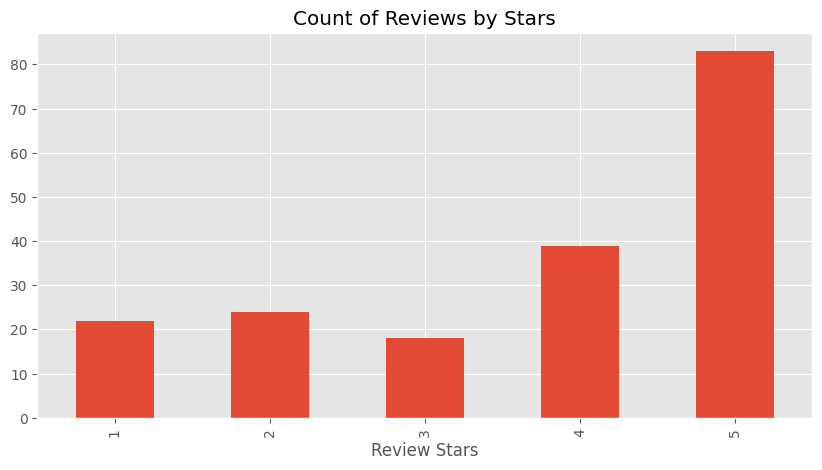

In [49]:
ax = df['Rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Stars',
          figsize=(10, 5))
ax.set_xlabel('Review Stars')
plt.show()

#Basic NLTK


In [51]:
example = df['Review'].iloc[51]
print(example)

Not fitting well not good


In [52]:
tokens = nltk.word_tokenize(example)
tokens[:]

['Not', 'fitting', 'well', 'not', 'good']

In [53]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Not', 'RB'),
 ('fitting', 'VBG'),
 ('well', 'RB'),
 ('not', 'RB'),
 ('good', 'JJ')]

In [54]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S Not/RB fitting/VBG well/RB not/RB good/JJ)


#Step 1: VADER Sentiment Scoring
We will use NLTK's SentimentIntensityAnalyzer to get the neg/neu/pos scores of the text.

This uses a "bag of words" approach:
Stop words are removed
each word is scored and combined to a total score.

In [55]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [56]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [57]:
sia.polarity_scores('This is the worst thing ever.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [58]:
sia.polarity_scores(example)

{'neg': 0.584, 'neu': 0.416, 'pos': 0.0, 'compound': -0.4973}

In [59]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Review']
    myid = row['Unnamed: 0']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/186 [00:00<?, ?it/s]

In [60]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Unnamed: 0'})
vaders = vaders.merge(df, how='left')

In [62]:
# Now we have sentiment score and metadata
vaders.head()

,Unnamed: 0,neg,neu,pos,compound,ID,BrandName,ItemCode,Rating,Review,...,Month,Year,UserCertified,Place,VaderScores,Negative,Neutral,Positive,Compound,Sentiment
0,13,0.000,0.475,0.525,0.9356,13,indi_club,bZtFJ6hceT,5,I love this product. The fabric of this item i...,...,Oct,2022.0,Certified Buyer,Sangli District,"{'neg': 0.0, 'neu': 0.475, 'pos': 0.525, 'comp...",0.000,0.475,0.525,0.9356,positive
1,14,0.000,0.506,0.494,0.5994,14,indi_club,bZtFJ6hceT,4,Super quality and fitting 👌 🥰😍🤩,...,Oct,2022.0,Certified Buyer,Mysuru,"{'neg': 0.0, 'neu': 0.506, 'pos': 0.494, 'comp...",0.000,0.506,0.494,0.5994,positive
2,15,0.000,0.527,0.473,0.5563,15,indi_club,bZtFJ6hceT,5,This product is very comfortable,...,Dec,2022.0,Certified Buyer,Angul,"{'neg': 0.0, 'neu': 0.527, 'pos': 0.473, 'comp...",0.000,0.527,0.473,0.5563,positive
3,16,0.756,0.244,0.000,-0.4767,16,indi_club,bZtFJ6hceT,1,Poor Quality..,...,Oct,2022.0,Certified Buyer,Cachar District,"{'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'comp...",0.756,0.244,0.000,-0.4767,negative
4,17,0.000,0.748,0.252,0.4019,17,indi_club,bZtFJ6hceT,5,Price justified the qualityGood quality at the...,...,May,2023.0,Certified Buyer,Hugli District,"{'neg': 0.0, 'neu': 0.748, 'pos': 0.252, 'comp...",0.000,0.748,0.252,0.4019,positive


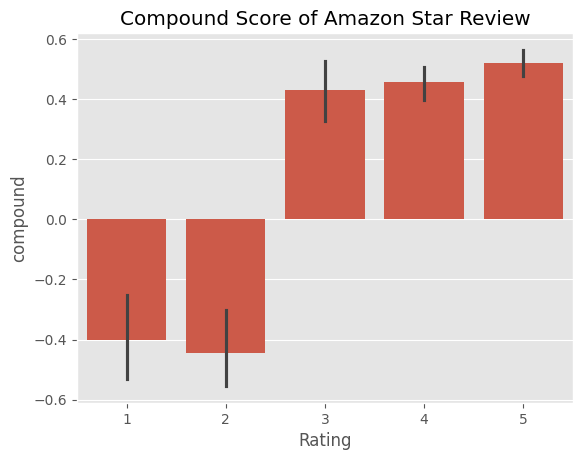

In [63]:
ax = sns.barplot(data=vaders, x='Rating', y='compound')
ax.set_title('Compound Score of Amazon Star Review')
plt.show()

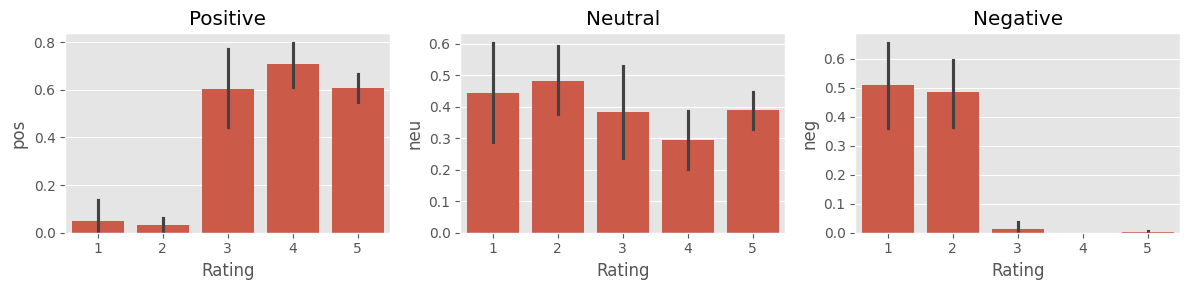

In [64]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Rating', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Rating', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Rating', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

#Step 2: Roberta Pretrained Model
Use a model trained of a large corpus of data.
Transformer model accounts for the words but also the context related to other words.

In [65]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [66]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [67]:
# VADER results on example
print(example)
sia.polarity_scores(example)

Not fitting well not good


{'neg': 0.584, 'neu': 0.416, 'pos': 0.0, 'compound': -0.4973}

In [70]:
# Run for Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.96755755, 'roberta_neu': 0.029721191, 'roberta_pos': 0.0027212515}


In [71]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [72]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Review']
        myid = row['Unnamed: 0']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/186 [00:00<?, ?it/s]

In [73]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'Unnamed: 0'})
results_df = results_df.merge(df, how='left')

In [74]:
results_df.columns

Index(['Unnamed: 0', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'ID', 'BrandName',
       'ItemCode', 'Rating', 'Review', 'UserName', 'Month', 'Year',
       'UserCertified', 'Place', 'VaderScores', 'Negative', 'Neutral',
       'Positive', 'Compound', 'Sentiment'],
      dtype='object')

#Step 3: Combine and compare

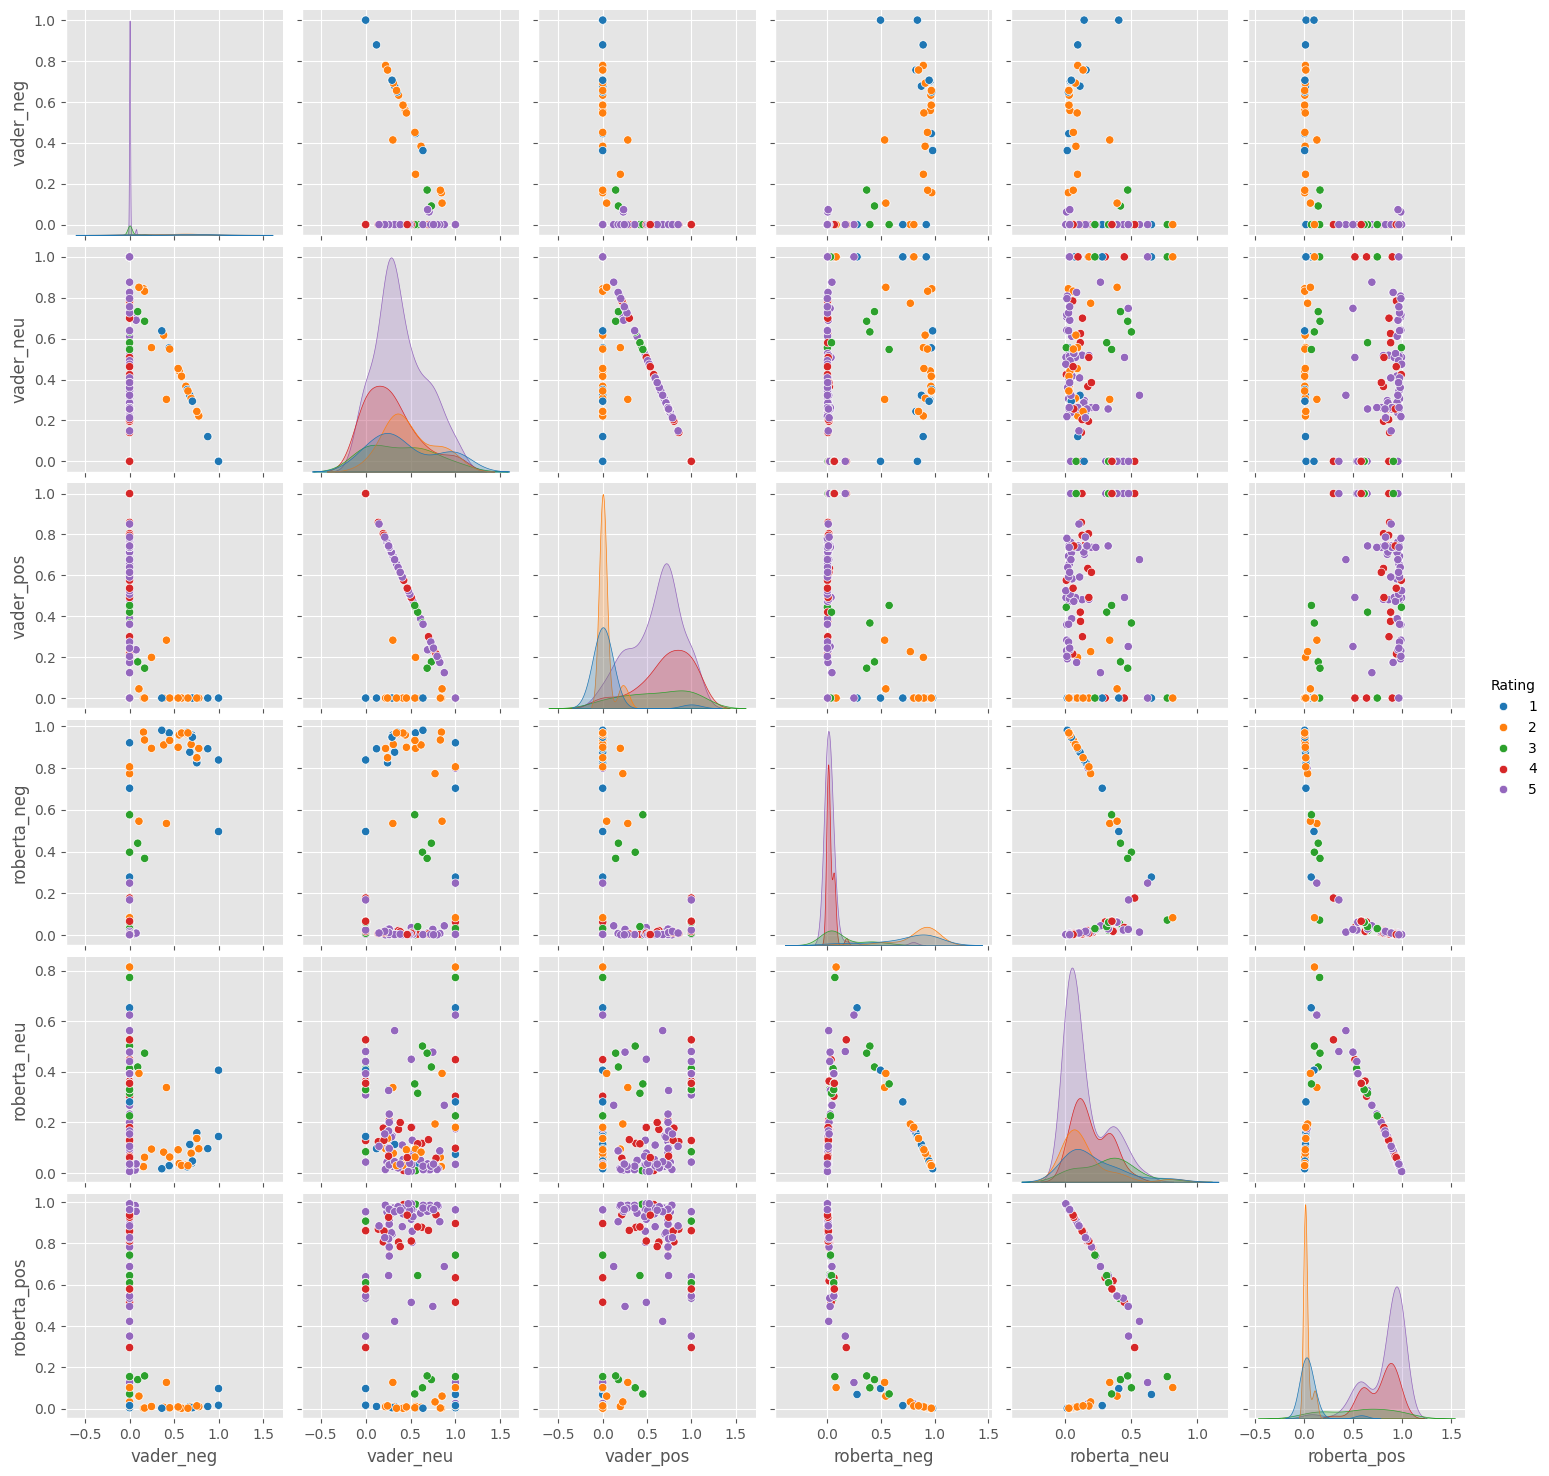

In [75]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='Rating',
            palette='tab10')
plt.show()

#Step 4: Review Examples:
Positive 1-Star and Negative 5-Star Reviews
Examples where the model scoring and review score differ the most.

In [76]:
results_df.query('Rating == 1') \
    .sort_values('roberta_pos', ascending=False)['Review'].values[0]

'Nice'

In [77]:
results_df.query('Rating == 1') \
    .sort_values('vader_pos', ascending=False)['Review'].values[0]

'Nice'

In [78]:
# negative sentiment 5-Star view
results_df.query('Rating == 5') \
    .sort_values('roberta_neg', ascending=False)['Review'].values[0]

'Nothing else 😒'

In [79]:
results_df.query('Rating == 5') \
    .sort_values('vader_neg', ascending=False)['Review'].values[0]

'I am little bit confused when I ordered,but now i am too happy when I received this product.So high quality product and packing is also nice.'